In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from xgboost import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [19]:

def create_features(df):
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    
    # Sine and cosine transformations for cyclic features
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df.dropna()
    
    return df

In [20]:
def add_lags(df):
    target_map = df['oxygenValue'].to_dict()
    df['lag_1']=(df.index - pd.Timedelta('1 day')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 day')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 day')).map(target_map)
    return df

In [21]:
df = pd.read_parquet('../data/cleanedData/allData.parquet')
df.set_index('measurementDate', inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525347 entries, 2021-01-01 00:01:00 to 2021-12-31 23:59:00
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   oxygenValue         525347 non-null  float64
 1   nitrateValue        525347 non-null  float64
 2   phosphateValue      525347 non-null  float64
 3   ammoniumValue       525347 non-null  float64
 4   waterFlowPerMinute  525347 non-null  float64
 5   precipitation       525347 non-null  float64
dtypes: float64(6)
memory usage: 28.1 MB


In [22]:
tss = TimeSeriesSplit(n_splits=8, test_size=60*24*30, gap=60*24)
df = df.sort_index()

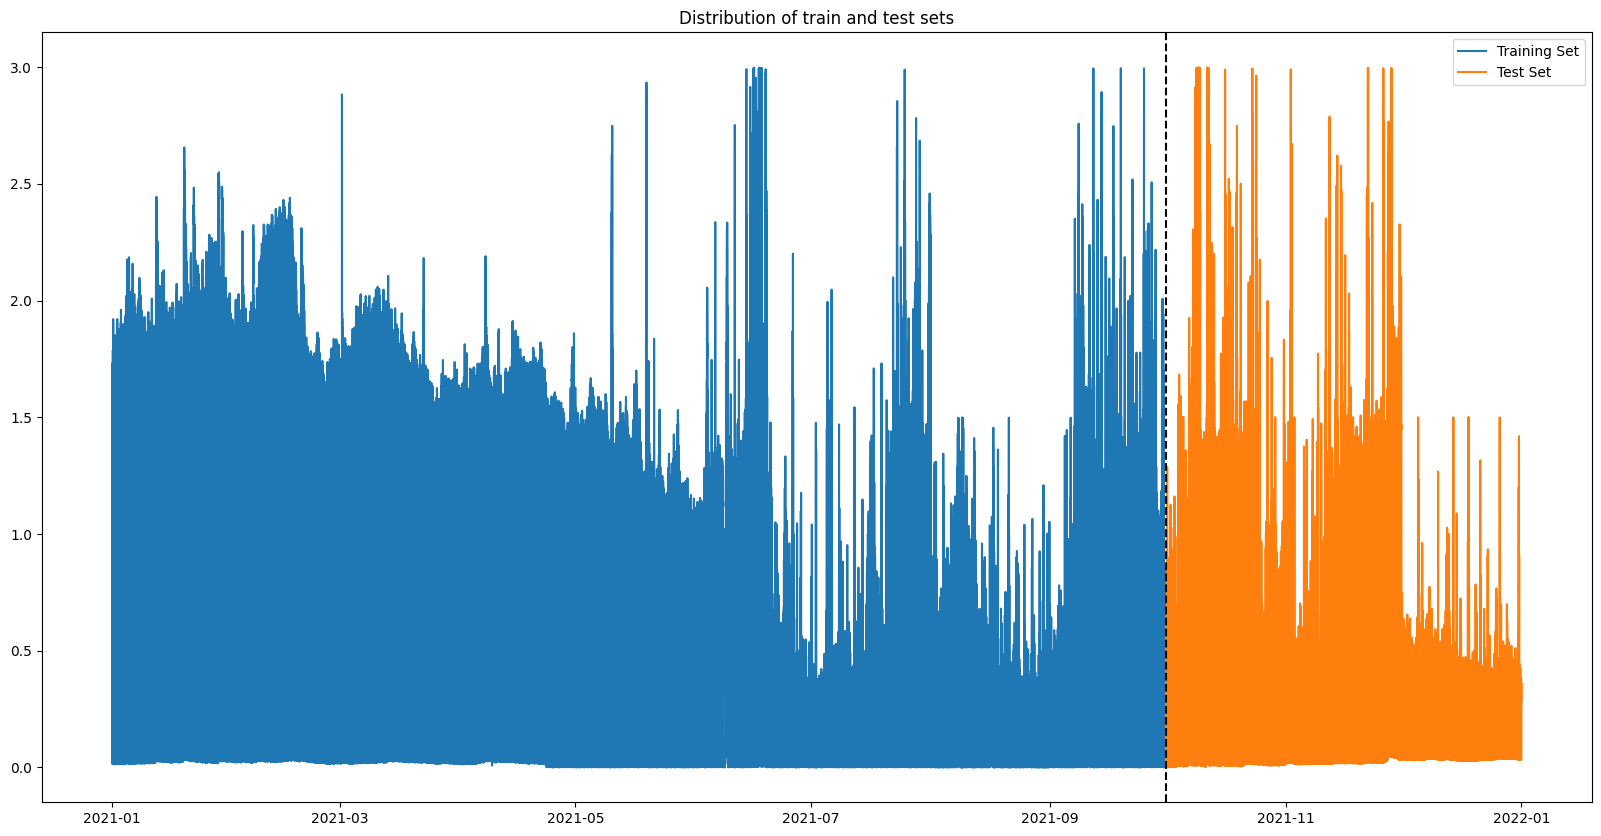

In [23]:
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train.index,train['oxygenValue'])
plt.plot(test.index,test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

In [24]:
FEATURES = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
            'waterFlowPerMinute', 'precipitation', 'minute_sin', 'minute_cos',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
            'quarter_sin', 'quarter_cos', 'month_sin', 'month_cos',
            'lag_1', 'lag_2', 'lag_3']
TARGET = 'oxygenValue'

df = create_features(df)
df= add_lags(df)
train = df.loc[df.index<'2021-10-01']
test = df.loc[df.index>='2021-10-01']
X_train_data, y_train_data = train[FEATURES],train[FEATURES]
X_test_data, y_test_data = test[FEATURES],test[FEATURES]

In [25]:
scaler = StandardScaler()
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.transform(X_test_data)

In [26]:
fold = 0
preds =[]
scores =[]
r2_scores = []
mae_scores = []

paramsRF = {
    "bootstrap": True,
    "ccp_alpha": 0.0,
    "criterion": "squared_error",
    "max_depth": 10,
    "max_features": "sqrt",
    "max_leaf_nodes": None,
    "max_samples": None,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 1,
    "min_samples_split": 6,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 200,
    "n_jobs": -1,
    "oob_score": False,
    "random_state": None,
    "verbose": 0,
    "warm_start": False
}

for train_idx, val_idx in tss.split(X_train_data):
    train = df.iloc[train_idx].copy()
    test = df.iloc[val_idx].copy()

    train = create_features(train)
    test = create_features(test)
    
    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]
    y_train.dropna()

    reg = RandomForestRegressor(**paramsRF)
    reg.fit(X_train, y_train)
    fold += 1

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test, y_pred)
    scores.append(score)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)


SyntaxError: '{' was never closed (682849197.py, line 7)

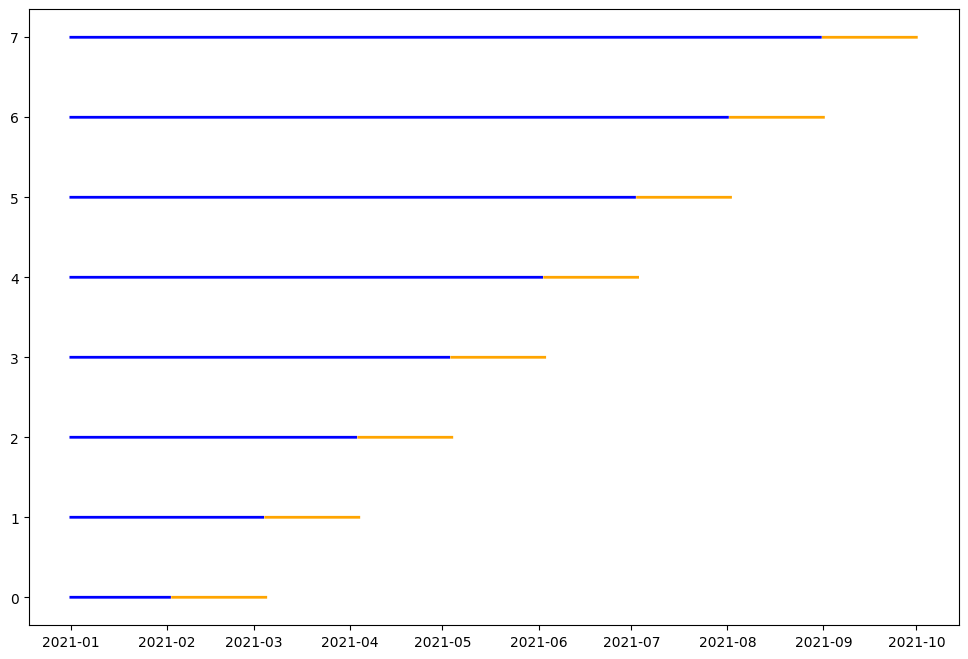

In [ ]:
splits = list(tss.split(X_train_data))[::-1]
plt.figure(figsize=(12, 8))

for i, (train_idx, test_idx) in enumerate(splits):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]or: 0.4851ange', linewidth=2)



In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

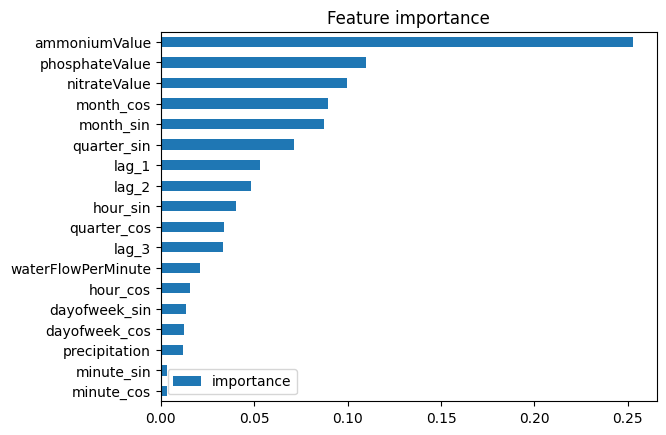

In [ ]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [ ]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')
print(f'R2 score across the folds:  {np.mean(r2_scores):0.4f}')
#print(f'Fold R2 scores: {r2_scores}')
print(f'Mean Absolute Error: {np.mean(mae_scores):0.4f}')
print(f'Mean Absolute Errors per fold: {mae_scores}')

Score across folds: 0.5628
Fold scores: [0.7411238606596446, 0.7022721408397332, 0.6469177173721522, 0.5544555237793286, 0.5846998267268451, 0.4704977978627211, 0.29787926476242527, 0.5047946124375927]
R2 score across the folds:  0.0533
Mean Absolute Error: 0.4851
Mean Absolute Errors per fold: [0.6736856971410395, 0.6115150420690354, 0.5898945201779097, 0.4928093774250898, 0.4936991901382385, 0.3451993059971625, 0.24206339676708202, 0.431998746327682]


In [ ]:
HYPER_PARAMETERS_DF: pd.DataFrame

try:
   HYPER_PARAMETERS_DF =  pd.read_csv('hyperParameters.csv')
except:
    HYPER_PARAMETERS_DF = pd.DataFrame(columns=[
        "bootstrap", "ccp_alpha", "criterion", "max_depth", 
        "max_features", "max_leaf_nodes", "max_samples", 
        "min_impurity_decrease", "min_samples_leaf", "min_samples_split",
        "min_weight_fraction_leaf", "n_estimators", "n_jobs", "oob_score", 
        "random_state", "verbose", "warm_start", "MAE", "RMSE"or: 0.4851
    ])

new_row = pd.DataFrame([paramsRF])
new_row['MAE'] = np.mean(mae_scores)
new_row['RMSE'] = np.mean(scores)
HYPER_PARAMETERS_DF = pd.concat([HYPER_PARAMETERS_DF, new_row], ignore_index=True)

HYPER_PARAMETERS_DF.to_csv('hyperParameters.csv', index=False)

In [ ]:

y_test_data['prediction'] = reg.predict(X_test_data)
df= df.merge(y_test_data[['prediction']],how='left',left_index=True,right_index=True)

/home/simon/schoolPrograming/DDD-DTW/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


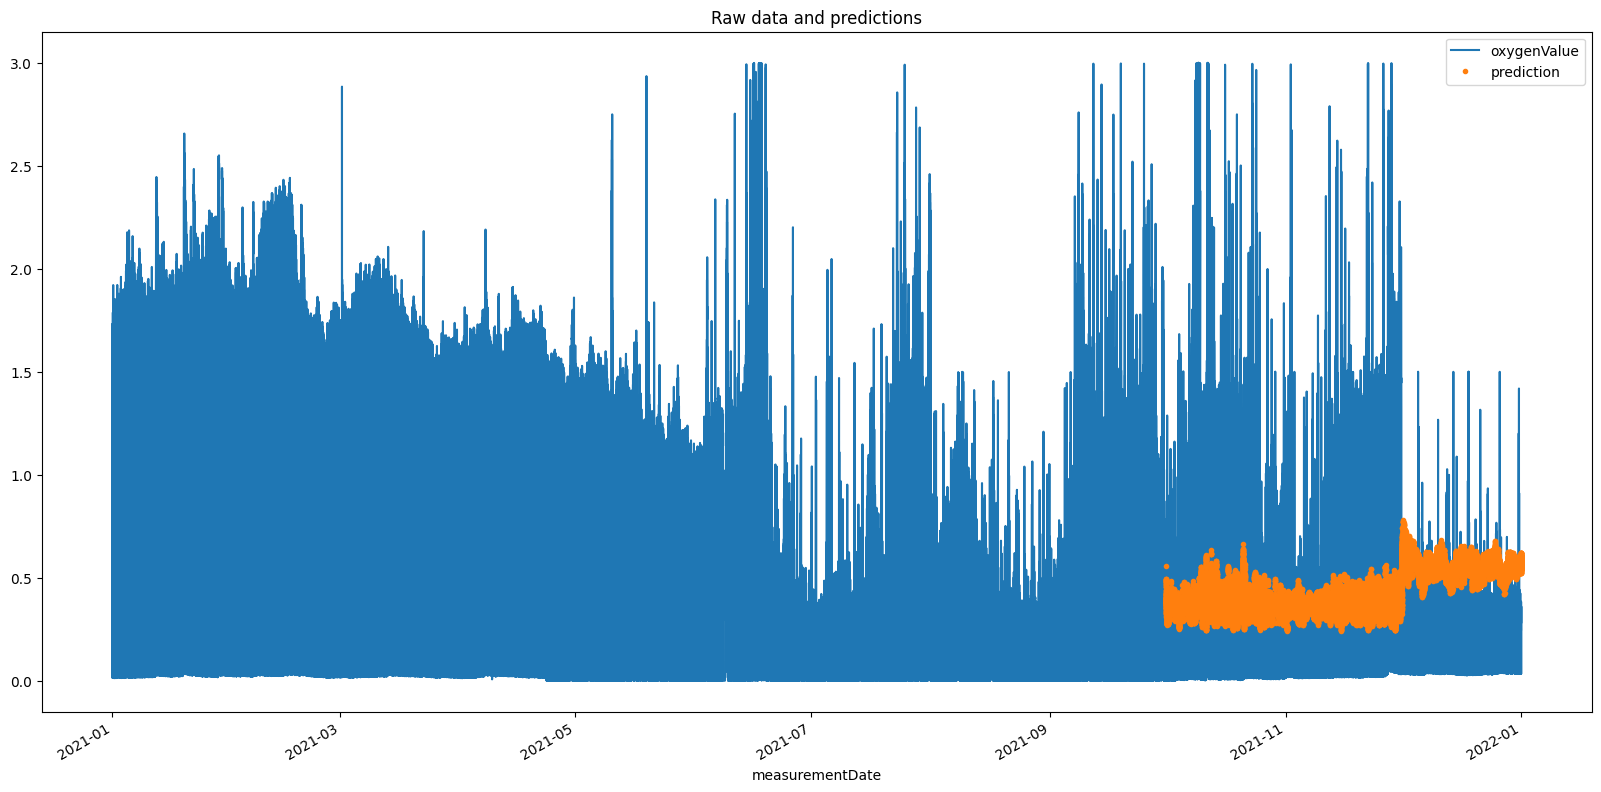

In [ ]:
ax = df[['oxygenValue']].plot(figsize=(20,10))
df['prediction'].plot(ax=ax,style='.')
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()

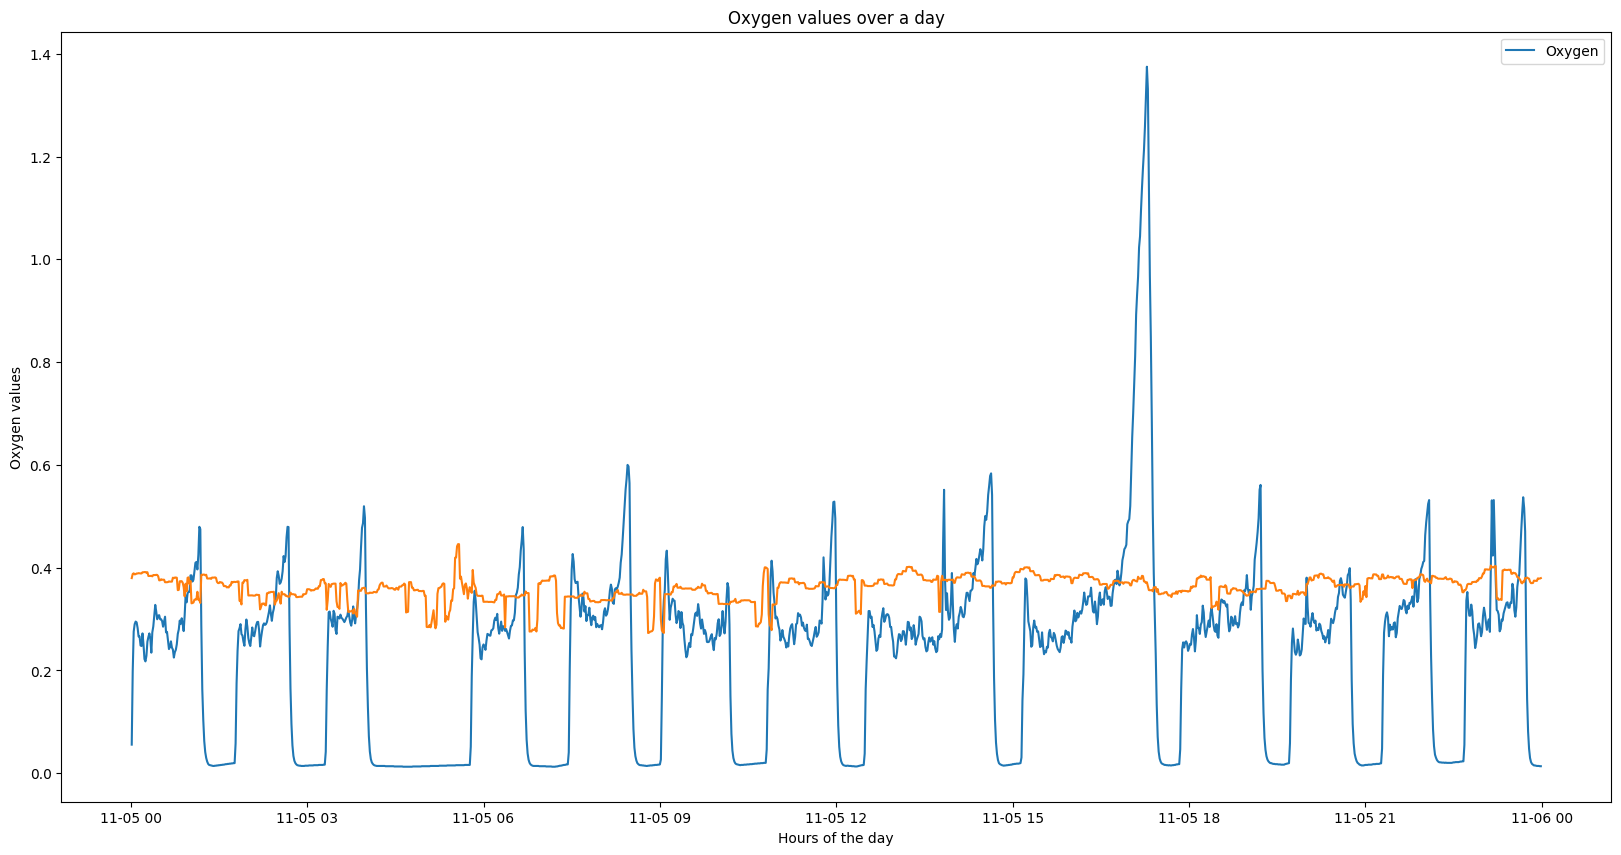

In [ ]:
day = df.loc[(df.index > '2021-11-05') & (df.index < '2021-11-06')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a day")
plt.plot(day.index,day['oxygenValue'])
plt.plot(day.index,day['prediction'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen"])